# Abstract
Clustering techniques can be applied to many different machine learning and data mining problems. This notebook will go through a detailed example of several clustering techniques applied to operational segmentation and outlier detection. This tutorial begins with a general overview of the general types of clustering methods, and will provided a brief description of several common clustering algorithms. This is followed by a discussion of the application of clustering to the outlier detection problem and an applied example with a real data set.

## Background


## Categories of Clustering
### Density Based Clustering
### Distance Based Clustering

## Popular Clustering Methods

Note Here
### k-means


The k-means clustering algorithm is often the first method taught when learning clustering methods. It partitions n observations into k clusters in which each observation belongs to the cluster with the nearest mean. The value of k is provided as an input to the algorithm. The algorithm is susceptible for the initial guesses of cluster centers, so typically the implementations provided use multiple guesses for the cluster centers.

The code below reads in a data file and ``drops`` columns that are not needed. In this data set, x, y, and z are measurements from an accelerometer.

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Read and delete unnecessary columns
input_data = pd.read_csv('activities.csv')
input_data.set_index('Index')
input_data.drop('Index', axis=1, inplace=True)
input_data.drop('Label', axis=1, inplace=True)

input_data = input_data.sample(10000, random_state = 1)
input_data.head()

,x,y,z
13199,1953,2369,2118
75292,1870,2386,1993
12593,1958,2376,2106
31211,1962,2371,2133
52664,1898,2400,2006


Some description and notes about what I see in the data here. Look at the columns of parameter z


In [2]:
input_data.describe()

,x,y,z
count,10000.000000,10000.000000,10000.00000
mean,1910.615700,2380.093900,2042.21490
std,41.307244,41.937617,59.68727
min,1567.000000,1963.000000,1802.00000
25%,1886.000000,2374.000000,1992.00000
50%,1905.000000,2381.000000,2025.00000
75%,1936.000000,2386.000000,2103.00000
max,2227.000000,2678.000000,2345.00000


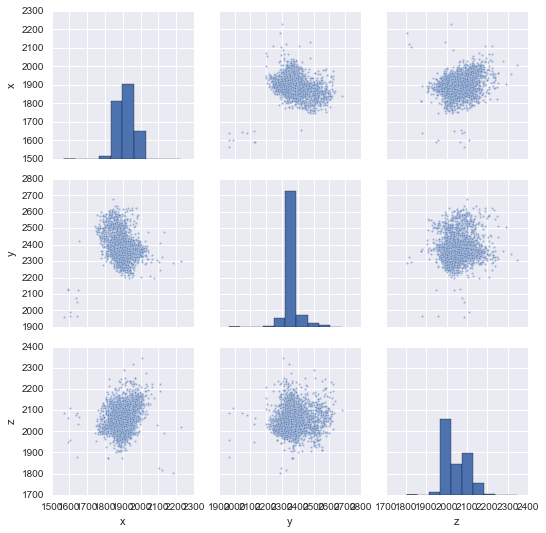

In [3]:
sns.pairplot(input_data, vars = ['x','y', 'z'],markers=".", plot_kws={'alpha':0.5})

Optimally choose the correct number of clusters by choosing the maximum of the silhouette coefficient.

In [1]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
import operator

X = input_data[['x','y','z']]

def score_cluster_model(num_clusters, input_df, cluster_model):
    model = cluster_model(num_clusters).fit(input_df)
    return silhouette_score(X, model.labels_)

silhouette_scores =   {n: score_cluster_model(n, X, KMeans) for n in range(2,10)}
plt.plot(silhouette_scores.keys(), silhouette_scores.values())
max_key = max(scores.iteritems(), key=operator.itemgetter(1))[0]

NameError: name 'input_data' is not defined

In [5]:
from sklearn.mixture import DPGMM
from sklearn.cluster import KMeans

final_kmeans_model = KMeans(n_clusters=max_key).fit(X)
labels = final_kmeans_model.predict(X)

dpgmm_model = DPGMM(n_components=20,covariance_type = 'full', n_iter=1000)
n = dpgmm_model.fit(X)
results = n.predict(X)

In [17]:
input_data['predictions'] = results
input_data['predictions'] = input_data["predictions"].astype('category')
grouped = input_data.groupby('predictions')

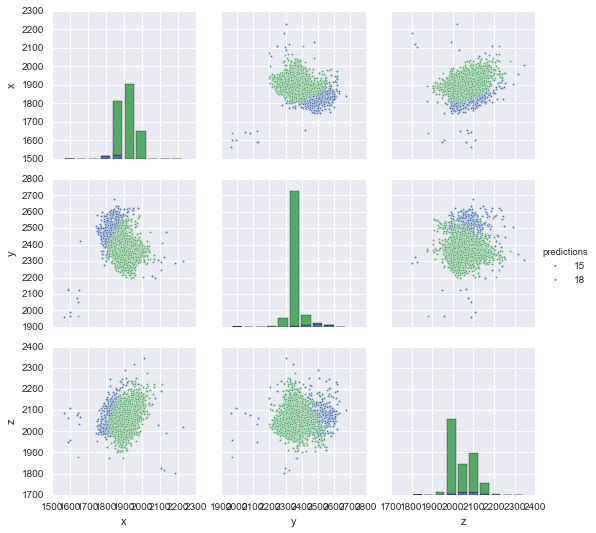

In [7]:
sns.pairplot(input_data, vars = ['x','y', 'z'],hue = "predictions",markers=".")

There are various metrics that can be used to determine if a given point is an outlier. One method is to find the minimum distance between a point and the center of the closest cluster. Many of the cluster algorithms will output the cluster centers as a parameter that is returned after calling the fit method. The scikit-learn package also has built-in tools for calculating the pair-wise distances between arrays of points. 

There are a wide variety of types of distance calculations available (i.e. manhattan, mahalanobis, euclidean, etc.)

Valid values for distance are:

    From scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]. These metrics support sparse matrix inputs.

    From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] 

In the calculations below, we calculate the minimum distance for each point. This represents the distance from every point to its closest cluster center. As a separate column we convert each distance to a rank. For eliminating outliers, you have choice of using a threshold for the minimum distance calculate, or for a more robust, non-parametric method you can identify a certain percentage of observations to remove using the rank. 


In [19]:
centers = final_kmeans_model.cluster_centers_
centers

array([[ 1894.47684666,  2374.6835443 ,  2003.18122096],
       [ 1950.69296899,  2371.04728278,  2114.39668407],
       [ 1851.23505976,  2506.05179283,  2059.17330677]])

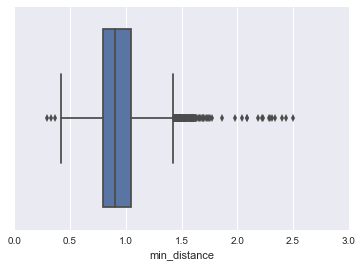

In [47]:
distances = pairwise_distances(X[['x','y', 'z']], Y=centers, metric='mahalanobis')
input_data['min_distance'] =np.amin(distances, axis=1)
input_data['outlier_rank'] = input_data['min_distance'].rank()
#sns.distplot(input_data['min_distance'])
input_data.head()
sns.boxplot(np.power(input_data['min_distance'], 1./3.))

> __Note:__ that the rank function used above has an optional argument that enable the rank function to directly return a percentage rather than an integer rank.

In [233]:
input_data['outlier_rank'].describe()

count    10000.000000
mean      5000.500000
std       2886.895674
min          1.000000
25%       2500.750000
50%       5000.500000
75%       7500.250000
max      10000.000000
Name: outlier_rank, dtype: float64

As a comparison point, we add a new categorical column called outliers and then show the plot 

6.89

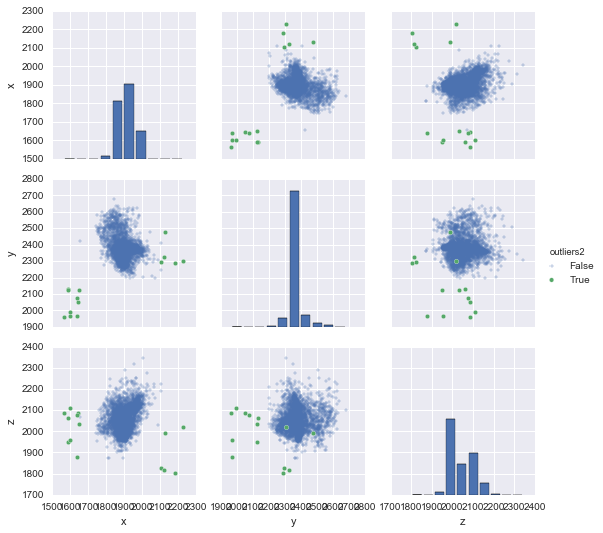

In [49]:
from  scipy.stats import chi2

cutoff = chi2.ppf(0.9975, 3)
cutoff = 6.89
input_data['outliers']= input_data.outlier_rank > 0.9975 * 10000
input_data['outliers2'] = input_data['min_distance'] > cutoff
#input_data.head()

sns.pairplot(input_data, vars = ['x','y', 'z'], hue = "outliers2", markers = ['+', 'o'])
cutoff

## Example2 : Gaussian Mixture Models

In this example, we will functionally do the same analysis as above, but instead of k-means and the silhouette score, we will use Gaussian Mixture Models as the clustering mechanisme and Bayesian Information as the model evaluation criteria for selecting the number of clusters.

In [10]:
from sklearn.mixture import GMM

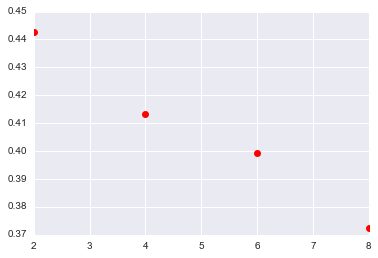

In [12]:
X = input_data[['x','y', 'z']]

num_clusters = range(2,11)

def score_gmm_model(num_components, input_df):
    gmm = GMM(n_components=num_components, covariance_type='full').fit(input_df)
    return silhouette_score(input_df, gmm.predict(input_df))

scores =   {n: score_gmm_model(n, X) for n in range(2,6)}

plt.plot(range(2,10, 2), scores.values(), 'ro')
